<a href="https://colab.research.google.com/github/SullyK/CNN_backup/blob/main/broken_bounding_boxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import csv
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import PIL
import numpy as np
from numpy import zeros
from numpy import asarray




In [4]:
!nvidia-smi

Wed Apr  6 15:47:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# import shutil

# shutil.rmtree('/content/Mask_RCNN')


In [6]:

# !git clone https://github.com/matterport/Mask_RCNN
# !git clone https://github.com/akTwelve/Mask_RCNN
!git clone https://github.com/SullyK/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 125.28 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (579/579), done.


In [7]:
os.chdir("/content/Mask_RCNN")

In [8]:
pip install -r requirements.txt


     |████████████████████████████████| 462 kB 33.6 MB/s 
     |████████████████████████████████| 154 kB 69.2 MB/s 
     |████████████████████████████████| 297 kB 68.2 MB/s 


In [9]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y




Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0


In [10]:
!pip install tensorflow==2.4.0
!pip install keras
!pip install h5py==2.10.0
!pip install Pillow



     |████████████████████████████████| 394.7 MB 16 kB/s 
     |████████████████████████████████| 14.8 MB 53.8 MB/s 
     |████████████████████████████████| 2.9 MB 66.5 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 132 kB 69.7 MB/s 
     |████████████████████████████████| 462 kB 68.8 MB/s 
     |████████████████████████████████| 3.8 MB 15.9 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68722 sha256=0fc49a811e19f3625b0cd9c9c3e6e37879385b60cc8ff7319f73f4d5525984dd
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy

     |████████████████████████████████| 1.4 MB 26.1 MB/s 


In [11]:
os.getcwd()

'/content/Mask_RCNN'

In [12]:
# Import Mask RCNN
ROOT_DIR = "/content/"
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


In [15]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


... done downloading pretrained model!


In [16]:
class sullyConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "MASKRCNN_CONFIG"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256 #Might have to put this back in
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    
config = sullyConfig()
# config.BATCH_SIZE = 16
config.display()




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [17]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  

In [18]:
class PlantDataset(utils.Dataset):
  def load_dataset(self,dataset_dir,is_train=True):
    self.add_class("dataset", 1, "leaf")


    images_dir = dataset_dir

    for filename in os.listdir(images_dir):
      image_id = filename[:-4] #remove the .png or w/e

      if "rgb" not in image_id: #check to see if it's the image(always has rgb)
        continue

      number = int(image_id[13:16])

      if is_train and number >= 100:
          continue

      if not is_train and number < 100:
          continue

      
      
      img_path = images_dir + "/" + filename
      ann_path = images_dir + "/" + image_id[:17] + 'bbox.csv'

      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)


  def extract_boxes(self,filename):
    file = open(filename)
    with open(filename, 'r') as csvfile:
      reader = csv.reader(csvfile)
      boxes = list()
      for row in reader:
        x_max = max(row[1],row[3],row[5],row[7])
        x_min = min(row[1],row[3],row[5],row[7])
        assert x_max >= x_min #xmax is always equal to or greater than x_min
        y_max = max(row[2],row[4],row[6],row[8])
        y_min = min(row[2],row[4],row[6],row[8])
        assert y_max >= y_min #ymax is always equal to or greater than x_min

        coors = [x_min,y_min,x_max,y_max]
        boxes.append(coors)
        image_name = filename[:-8] + "rgb.png"
        image = PIL.Image.open(image_name)
        width, height = image.size
        # print("width" + width)

        print(boxes)

        return boxes,width,height

  def load_mask(self,image_id):
    info = self.image_info[image_id]
    path = info['annotation']
    boxes, w,h = self.extract_boxes(path)
    masks = zeros([h, w, len(boxes)], dtype='uint8')
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e = int(box[1]), int(box[3])
      col_s, col_e = int(box[0]), int(box[2])
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('leaf'))
      return masks, asarray(class_ids, dtype='int32')

  def image_reference(self, image_id):
      info = self.image_info[image_id]
      print(info)
      return info['path']


    



        #Continue from here, this needs to be complete and then called for the 
        #above print statements to print












In [21]:
os.getcwd()

'/content/Mask_RCNN'

In [22]:
# Training dataset
train_set = PlantDataset()
train_set.load_dataset('/content/drive/MyDrive/Plant/Ara2012', is_train=True)
train_set.prepare()
print('training set: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = PlantDataset()
test_set.load_dataset('/content/drive/MyDrive/Plant/Ara2012', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


#It has 61, should fix this...

training set: 99
Test: 21


[['104', '155', '85', '223']]


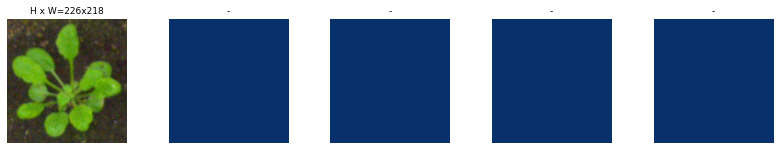

[['197', '222', '327', '324']]


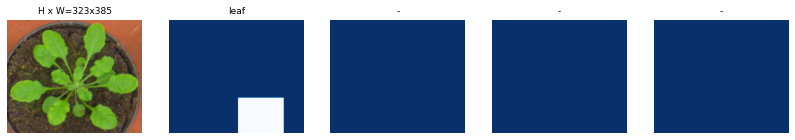

[['144', '109', '211', '98']]


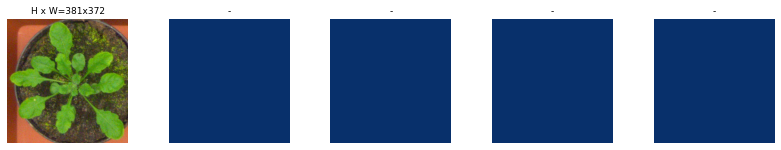

[['102', '178', '180', '293']]


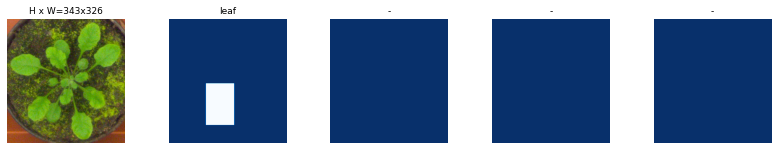

[['140', '132', '205', '186']]


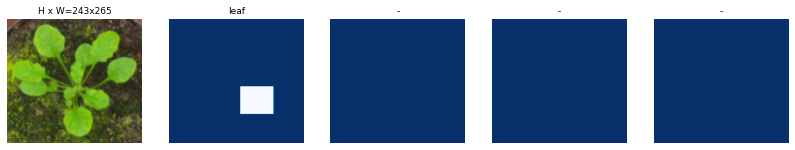

[['104', '155', '85', '223']]


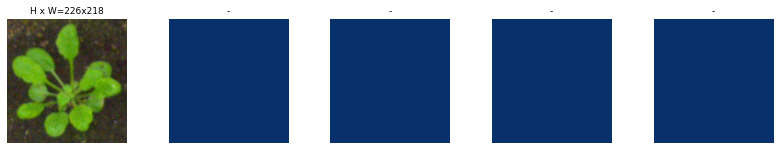

[['109', '144', '184', '38']]


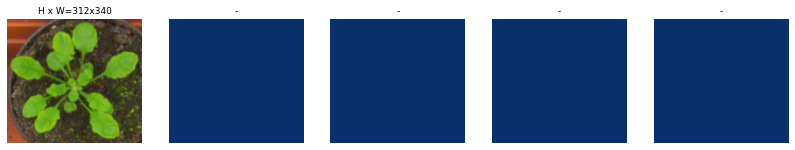

[['216', '178', '318', '323']]


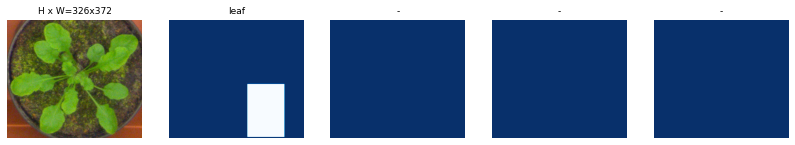

[['111', '106', '75', '75']]


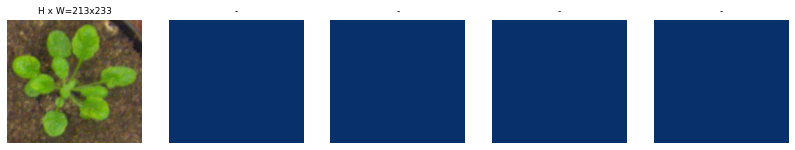

[['111', '106', '75', '75']]


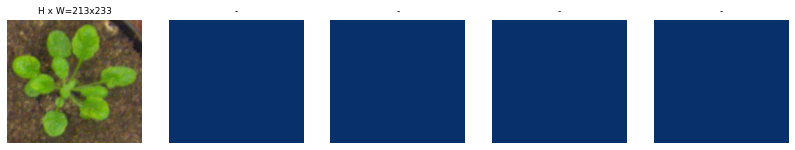

In [28]:
image_ids = np.random.choice(train_set.image_ids, 10)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)


In [24]:
# # Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 4)
# for image_id in image_ids:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


In [25]:
print("Loading Mask R-CNN model...")

model = modellib.MaskRCNN(mode="training", config=config, 
                          model_dir='./')
os.getcwd()


Loading Mask R-CNN model...


'/content/Mask_RCNN'

In [26]:
#load the weights for COCO
model.load_weights('/content/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


In [27]:
model.train(train_set, test_set, learning_rate=0.0009, epochs=4, layers="heads")
history = model.keras_model.history.history



Starting at epoch 0. LR=0.0009

Checkpoint Path: ./maskrcnn_config20220406T1551/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Tim

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['180', '129', '226', '167']]
[['13', '100', '8', '85']]
[['210', '181', '356', '372']]
[['139', '11', '197', '134']]
[['164', '180', '194', '198']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['112', '171', '163', '223']]
[['111', '108', '97', '8']]
[['164', '180', '194', '198']]
[['185', '170', '201', '181']]
[['123', '118', '147', '142']]
[['100', '113', '21', '93']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['111', '106', '75', '75']]
[['143', '210', '98', '99']]
[['208', '108', '272', '177']]
[['122', '131', '214', '3']]
[['114', '126', '202', '2']]
[['144', '109', '211', '98']]
[['102', '191', '195', '277']]
[['241', '216', '365', '283']]
[['135', '11', '192', '131']]
[['115', '181', '96', '249']]
[['102', '103', '160', '9']]
[['114', '132', '99', '182']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['241', '216', '365', '283']]
[['234', '188', '390', '96']]
[['187', '111', '86', '218']]
[['184', '112', '242', '177']]
[['111', '242', '217', '397']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['110', '114', '160', '165']]
[['16', '145', '7', '235']]
[['230', '209', '279', '251']]
[['106', '172', '79', '263']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['184', '112', '242', '177']]
[['186', '128', '76', '70']]
[['111', '242', '217', '397']]
[['113', '113', '89', '161']]
[['13', '100', '8', '85']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['196', '183', '255', '281']]
[['116', '162', '144', '207']]
[['114', '10', '170', '12']]
[['200', '185', '261', '287']]
[['159', '124', '5', '76']]
[['142', '128', '97', '199']]
[['133', '145', '92', '90']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['113', '177', '87', '246']]
[['117', '122', '145', '151']]
[['23', '11', '94', '75']]
[['185', '170', '201', '181']]
[['184', '112', '242', '177']]
[['230', '209', '279', '251']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['102', '103', '160', '9']]
[['184', '112', '242', '177']]
[['118', '34', '196', '95']]
[['103', '192', '170', '258']]
[['216', '178', '318', '323']]
[['254', '141', '299', '190']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['117', '122', '145', '151']]
[['160', '198', '308', '324']]
Epoch 1/4
[['277', '154', '312', '203']]
[['185', '170', '201', '181']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['137', '140', '216', '8']]
[['230', '209', '279', '251']]
[['181', '110', '232', '190']]
[['102', '103', '160', '9']]
[['196', '183', '255', '281']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['137', '140', '216', '8']]
[['124', '203', '170', '261']]
[['143', '210', '98', '99']]
[['111', '106', '75', '75']]
[['10', '112', '12', '89']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['230', '209', '279', '251']]
[['111', '106', '75', '75']]
[['140', '-1', '281', '35']]
[['110', '103', '164', '98']]
[['124', '118', '185', '93']]
[['102', '178', '180', '293']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. Thi

[['241', '138', '319', '199']]
[['125', '265', '228', '417']]
[['208', '108', '272', '177']]
[['111', '108', '97', '8']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['183', '137', '348', '66']]
[['126', '130', '151', '160']]
[['175', '113', '224', '186']]
[['234', '188', '390', '96']]
[['122', '131', '214', '3']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['103', '192', '170', '258']]
[['190', '121', '225', '173']]
[['208', '108', '272', '177']]
[['123', '109', '219', '198']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['105', '113', '84', '212']]
[['196', '183', '255', '281']]
[['139', '11', '197', '134']]
[['135', '11', '192', '131']]
[['151', '174', '179', '199']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['200', '185', '261', '287']]
[['277', '154', '312', '203']]
[['195', '113', '244', '162']]
[['104', '182', '171', '293']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['241', '216', '365', '283']]
[['166', '145', '282', '219']]
[['165', '143', '201', '189']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['220', '245', '284', '310']]
[['123', '109', '219', '198']]
[['122', '-0', '221', '19']]
[['142', '128', '97', '199']]
[['108', '147', '72', '234']]
[['111', '242', '217', '397']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['118', '34', '196', '95']]
[['186', '128', '76', '70']]
[['175', '113', '344', '80']]
[['164', '180', '194', '198']]
[['164', '211', '217', '257']]
[['197', '222', '327', '324']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['102', '178', '180', '293']]
[['126', '130', '151', '160']]
[['197', '222', '327', '324']]
[['196', '183', '255', '281']]
[['164', '180', '194', '198']]
[['125', '265', '228', '417']]
[['114', '126', '202', '2']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['241', '216', '365', '283']]
[['222', '200', '266', '241']]
[['166', '145', '282', '219']]
[['164', '180', '194', '198']]
[['222', '200', '266', '241']]
[['106', '172', '79', '263']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['122', '131', '214', '3']]
[['135', '11', '192', '131']]
[['111', '108', '97', '8']]
[['165', '143', '201', '189']]
[['124', '118', '185', '93']]
[['124', '203', '170', '261']]
[['133', '145', '92', '90']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['186', '128', '76', '70']]
[['144', '109', '211', '98']]
[['119', '108', '164', '95']]
[['124', '203', '170', '261']]
[['110', '103', '164', '98']]
[['223', '142', '322', '209']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['220', '245', '284', '310']]
[['103', '192', '170', '258']]
[['113', '177', '87', '246']]
[['106', '172', '79', '263']]
[['111', '108', '97', '8']]
[['184', '112', '242', '177']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['180', '129', '226', '167']]
[['103', '192', '170', '258']]
[['102', '103', '160', '9']]
[['104', '182', '171', '293']]
[['105', '113', '84', '212']]
[['184', '112', '242', '177']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['254', '141', '299', '190']]
[['241', '138', '319', '199']]
[['133', '145', '92', '90']]
[['195', '113', '244', '162']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['120', '116', '143', '139']]
 98/100 [============================>.] - ETA: 0s - batch: 48.5000 - size: 1.0000 - loss: 2.1330 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 0.7077 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.7759 - mrcnn_mask_loss: 0.4306[['116', '162', '144', '207']]
[['185', '177', '203', '190']]
[['13', '100', '8', '85']]
 99/100 [============================>.] - ETA: 0s - batch: 49.0000 - size: 1.0000 - loss: 2.1309 - rpn_class_loss: 0.1006 - rpn_bbox_loss: 0.7186 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.7681 - mrcnn_mask_loss: 0.4263[['222', '200', '266', '241']]
[['13', '100', '8', '85']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['112', '102', '5', '72']]
[['103', '192', '170', '258']]
[['118', '34', '196', '95']]
100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 2.1294 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 0.7128 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.7715 - mrcnn_mask_loss: 0.4279[['127', '108', '98', '30']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['137', '140', '216', '8']]
[['228', '264', '294', '330']]
[['210', '181', '356', '372']]
[['131', '101', '80', '151']]
[['122', '-0', '221', '19']]
[['120', '224', '175', '272']]
[['139', '11', '198', '133']]
[['123', '109', '219', '198']]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be ra

[['166', '194', '238', '270']]
[['125', '265', '228', '417']]
[['225', '185', '322', '335']]
[['11', '159', '188', '217']]
[['112', '171', '163', '223']]
[['111', '199', '182', '282']]
[['165', '143', '293', '237']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['161', '113', '205', '99']]
[['105', '135', '132', '168']]
[['166', '194', '238', '270']]
[['126', '130', '151', '160']]
[['229', '296', '306', '382']]
[['165', '143', '201', '189']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['139', '11', '198', '133']]
[['114', '132', '99', '182']]
[['223', '142', '322', '209']]
[['111', '199', '182', '282']]
[['109', '144', '184', '38']]
[['-2', '136', '29', '271']]
[['187', '111', '86', '218']]
[['161', '198', '315', '337']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['23', '11', '94', '75']]
[['139', '11', '198', '133']]
[['123', '118', '147', '142']]
[['11', '159', '188', '217']]
[['10', '112', '12', '89']]
[['228', '264', '294', '330']]
[['180', '129', '226', '167']]
[['118', '235', '168', '334']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['143', '210', '98', '99']]
[['161', '113', '205', '99']]
[['186', '128', '76', '70']]
[['124', '155', '82', '8']]
[['197', '222', '327', '324']]
[['111', '199', '182', '282']]
[['190', '121', '225', '173']]
[['111', '101', '7', '87']]
[['124', '203', '170', '261']]
[['120', '224', '175', '272']]
[['183', '251', '274', '366']]
[['136', '231', '83', '392']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['139', '11', '198', '133']]
[['123', '109', '219', '198']]
[['161', '198', '315', '337']]
[['100', '113', '21', '93']]
[['222', '200', '266', '241']]
[['176', '145', '321', '269']]
[['102', '103', '160', '9']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['118', '235', '168', '334']]
[['254', '141', '299', '190']]
[['183', '251', '274', '366']]
[['197', '222', '327', '324']]
[['216', '178', '318', '323']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['140', '-1', '281', '35']]
[['175', '113', '224', '186']]
[['133', '145', '92', '90']]
[['164', '211', '217', '257']]
[['223', '142', '322', '209']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['120', '116', '143', '139']]
[['100', '113', '21', '93']]
[['10', '112', '12', '89']]
[['164', '180', '194', '198']]
[['122', '131', '214', '3']]
[['13', '100', '8', '85']]
[['175', '113', '224', '186']]
[['187', '111', '86', '218']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['175', '113', '344', '80']]
[['118', '34', '196', '95']]
[['112', '102', '5', '72']]
[['186', '128', '76', '70']]
[['124', '118', '185', '93']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['225', '185', '322', '335']]
[['165', '143', '201', '189']]
[['112', '102', '5', '72']]
[['120', '116', '143', '139']]
[['112', '171', '163', '223']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['165', '143', '293', '237']]
[['175', '113', '224', '186']]
[['222', '200', '266', '241']]
[['114', '10', '170', '12']]
[['120', '116', '143', '139']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['190', '123', '274', '175']]
[['114', '126', '202', '2']]
[['216', '178', '318', '323']]
[['133', '145', '92', '90']]
[['115', '181', '96', '249']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['123', '118', '147', '142']]
[['151', '174', '179', '199']]
[['164', '180', '194', '198']]
[['151', '174', '179', '199']]
[['181', '110', '232', '190']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['222', '200', '266', '241']]
[['110', '114', '160', '165']]
[['142', '128', '97', '199']]
[['123', '118', '147', '142']]
[['122', '-0', '221', '19']]
[['277', '154', '312', '203']]
[['184', '112', '242', '177']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['164', '211', '217', '257']]
[['195', '113', '244', '162']]
[['110', '114', '160', '165']]
[['165', '143', '293', '237']]
[['139', '11', '197', '134']]
[['110', '103', '164', '98']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['185', '170', '201', '181']]
[['222', '200', '266', '241']]
[['149', '189', '99', '348']]
[['183', '251', '274', '366']]
[['123', '118', '147', '142']]
[['164', '211', '217', '257']]
[['135', '11', '192', '131']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['100', '113', '21', '93']]
[['115', '181', '96', '249']]
[['225', '185', '322', '335']]
[['186', '128', '76', '70']]
[['133', '145', '92', '90']]
[['111', '108', '97', '8']]
[['208', '108', '272', '177']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['102', '191', '195', '277']]
[['166', '145', '282', '219']]
[['103', '192', '170', '258']]
[['122', '131', '214', '3']]
[['114', '132', '99', '182']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['165', '143', '201', '189']]
[['210', '181', '356', '372']]
[['117', '122', '145', '151']]
[['119', '108', '164', '95']]
[['197', '231', '278', '300']]
[['254', '141', '299', '190']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['126', '130', '151', '160']]
[['118', '34', '196', '95']]
[['112', '171', '163', '223']]
[['108', '147', '72', '234']]
[['104', '155', '85', '223']]
[['114', '126', '202', '2']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['109', '144', '184', '38']]
[['200', '185', '261', '287']]
[['166', '145', '282', '219']]
[['111', '108', '97', '8']]
[['190', '121', '225', '173']]
[['111', '108', '97', '8']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['166', '145', '282', '219']]
[['234', '188', '390', '96']]
[['124', '118', '185', '93']]
[['151', '174', '179', '199']]
[['127', '108', '98', '30']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['111', '108', '97', '8']]
[['149', '189', '99', '348']]
[['119', '108', '164', '95']]
[['135', '11', '192', '131']]
[['234', '188', '390', '96']]
[['187', '111', '86', '218']]
[['175', '113', '344', '80']]
[['133', '145', '92', '90']]
[['186', '128', '76', '70']]
[['230', '209', '279', '251']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['151', '174', '179', '199']]
[['162', '110', '194', '122']]
[['222', '200', '266', '241']]
[['124', '203', '170', '261']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['105', '113', '84', '212']]
[['165', '143', '293', '237']]
[['112', '102', '5', '72']]
[['16', '145', '7', '235']]
[['183', '137', '348', '66']]
[['175', '113', '344', '80']]
[['149', '189', '99', '348']]
[['181', '110', '232', '190']]
[['234', '188', '390', '96']]
[['124', '118', '185', '93']]
[['175', '113', '224', '186']]
[['167', '143', '212', '187']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['197', '231', '278', '300']]
[['144', '109', '211', '98']]
[['185', '177', '203', '190']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - 64s 440ms/step - batch: 49.5000 - size: 1.0000 - loss: 2.1294 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 0.7128 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.7715 - mrcnn_mask_loss: 0.4279 - val_loss: 1.6338 - val_rpn_class_loss: 0.0522 - val_rpn_bbox_loss: 0.4544 - val_mrcnn_class_loss: 0.0698 - val_mrcnn_bbox_loss: 0.6550 - val_mrcnn_mask_loss: 0.4025
Epoch 2/4
 97/100 [============================>.] - ETA: 0s - batch: 48.0000 - size: 1.0000 - loss: 1.6563 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.6557 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.5060 - mrcnn_mask_loss: 0.3584[['195', '113', '244', '162']]
[['117', '122', '145', '151']]
[['105', '135', '132', '168']]
[['124', '203', '170', '261']]
[['122', '-0', '221', '19']]
 98/100 [============================>.] - ETA: 0s - batch: 48.5000 - size: 1.0000 - loss: 1.6635 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.6724 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.5009 - mrcnn_mask

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['102', '178', '180', '293']]
[['118', '34', '196', '95']]
[['277', '154', '312', '203']]
[['241', '216', '365', '283']]
[['104', '155', '85', '223']]
 99/100 [============================>.] - ETA: 0s - batch: 49.0000 - size: 1.0000 - loss: 1.6591 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.6668 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.3547

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['114', '132', '99', '182']]
[['200', '185', '261', '287']]
[['190', '123', '274', '175']]
[['127', '108', '98', '30']]
[['254', '141', '299', '190']]
[['181', '110', '232', '190']]
100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 1.6505 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.6610 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.5004 - mrcnn_mask_loss: 0.3550

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['104', '182', '171', '293']]
[['140', '10', '204', '131']]
[['277', '154', '312', '203']]
[['110', '114', '160', '165']]
[['114', '106', '92', '86']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['254', '141', '299', '190']]
[['175', '113', '344', '80']]
[['187', '111', '86', '218']]
[['102', '178', '180', '293']]
[['102', '178', '180', '293']]
[['167', '143', '212', '187']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['142', '128', '97', '199']]
[['167', '143', '212', '187']]
[['149', '189', '99', '348']]
[['135', '11', '192', '131']]
[['234', '188', '390', '96']]
[['165', '143', '201', '189']]
[['190', '121', '225', '173']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['226', '293', '300', '375']]
[['126', '107', '190', '87']]
[['131', '101', '80', '151']]
[['230', '209', '279', '251']]
[['111', '101', '7', '87']]
[['183', '137', '348', '66']]
[['120', '224', '175', '272']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['175', '113', '344', '80']]
[['106', '172', '79', '263']]
[['124', '155', '82', '8']]
[['241', '138', '319', '199']]
[['166', '194', '238', '270']]
[['197', '222', '327', '324']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

[['11', '159', '188', '217']]
[['126', '130', '151', '160']]
[['161', '198', '315', '337']]
[['167', '143', '212', '187']]
[['161', '113', '205', '99']]
[['195', '113', '244', '162']]


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


[['139', '11', '198', '133']]
[['195', '113', '244', '162']]
[['139', '11', '198', '133']]
[['127', '108', '98', '30']]
[['139', '11', '198', '133']]
[['185', '170', '201', '181']]
[['159', '124', '5', '76']]
[['161', '198', '315', '337']]
[['178', '11', '242', '202']]
[['131', '101', '80', '151']]
[['220', '155', '275', '227']]
[['110', '114', '160', '165']]
[['140', '10', '204', '131']]
[['164', '180', '194', '198']]
[['166', '194', '238', '270']]
[['117', '122', '145', '151']]
[['118', '235', '168', '334']]
[['142', '128', '97', '199']]
[['228', '264', '294', '330']]
[['116', '162', '144', '207']]
[['140', '10', '204', '131']]
[['140', '132', '205', '186']]
[['241', '216', '365', '283']]
[['175', '113', '344', '80']]
[['185', '170', '201', '181']]
[['180', '129', '226', '167']]
[['175', '113', '344', '80']]
[['122', '131', '214', '3']]
[['175', '113', '224', '186']]
[['114', '10', '170', '12']]
[['102', '178', '180', '293']]
[['178', '11', '242', '202']]
[['195', '113', '244', '162'

KeyboardInterrupt: ignored

In [ ]:
model_path = '/content/Mask_RCNN/maskrcnn_config20220406T1426/mask_rcnn_maskrcnn_config_0004.h5'
model.keras_model.save_weights(model_path)




In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)
img = load_img('/content/drive/MyDrive/Plant/Ara2012/ara2012_plant012_rgb.png')
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])


In [ ]:
image_id = 10
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, config, image_id)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")


In [ ]:
# # Test on a random image
# image_id = random.choice(dataset_val.image_ids)
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_val, inference_config, 
#                            image_id, use_mini_mask=False)
# # 
# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))


In [ ]:
# results = model.detect([original_image], verbose=1)

# r = results[0]
# # visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'], ax=get_ax())
